### Imports

In [1]:
from IPython.core.debugger import set_trace

#%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")

In [12]:
SENTIMENT_LABELLED_DATA_FILEPATH = '..\Data\Sentiment Analysis Dataset.csv'
DATA_PREPROCESSING_FILEPATH = '../Data Preprocessed'

TOKENIZER_OUTPUT_FILEPATH = 'tokenizer_100K_fin.pickle'
#TOKENIZER_OUTPUT_FILEPATH = 'tokenizer_1M.pickle'


# MODEL_OUTPUT_FILEPATH = 'model_1M_glove'
# MODEL_OUTPUT_FILEPATH = 'model_100K_glove'
MODEL_OUTPUT_FILEPATH = 'model_100K_glove'
# MODEL_OUTPUT_FILEPATH = 'model_100K_glove_91_X'

#### Dataset Import

In [3]:
txt_data = pd.read_csv(SENTIMENT_LABELLED_DATA_FILEPATH , sep='|', names=['col1'])

#split data into columns with ','
txt_data = txt_data.col1.str.split(',',  3, expand=True)
txt_data.columns = list(txt_data.iloc[0])
txt_data = txt_data.drop(0)
txt_data.index = np.subtract(txt_data.index, 1)


In [4]:
dataset = pd.concat([txt_data['SentimentText'], txt_data['Sentiment']], axis = 1)
dataset.columns = ['text', 'target']

In [7]:
#suffle
dataset = dataset.sample(frac = 1).reset_index(drop=True)
dataset

,text,target
0,@totallydreams Get 100 followers a day using w...,1
1,I don't want to present my project. it's so la...,0
2,"""@StarGrl85 yeah, i've tried sending a tweet 2...",0
3,@Ryan_Christof nigga u hear tht down the domin...,1
4,"""There was &quot;a problem with my Twitter fee...",0
...,...,...
1577833,looking for a fresh longboard deck,1
1577834,"""Was channelsurfing and came across &quot;Weak...",1
1577835,Finally home after a very full day! Had fun bu...,1
1577836,Good morning up at 630,0


#### NLP Imports

In [8]:
dataset.describe()

,text,target
count,1577838,1577838
unique,1577727,2
top,,1
freq,26,789771


In [9]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append(DATA_PREPROCESSING_FILEPATH)
from data_preprocess import *

import pickle

In [14]:
text = NLP_preprocess(dataset)
text.preprocess_data()

text.set_tokenizer()
import pickle

# saving
with open(TOKENIZER_OUTPUT_FILEPATH, 'wb') as handle:
    pickle.dump(text.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Preprocessing

#### Train / Test Split - Tokenization - Padding

In [60]:
train_dataset = dataset[:100000]
train_labels = train_dataset.target.astype(float)
train_padded = text.tokenize_and_pad(train_dataset, train = True)
print(train_padded)
# saving
with open(TOKENIZER_OUTPUT_FILEPATH, 'wb') as handle:
    pickle.dump(text.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

[[ 27840      4    498 ...      0      0      0]
 [     8     25   1646 ...      0      0      0]
 [ 27841     69     67 ...      0      0      0]
 ...
 [   190      6     87 ...      0      0      0]
 [ 15223     40    752 ...      0      0      0]
 [106989   1573      2 ...      0      0      0]]


In [61]:
text.set_embedding_matrix()

In [62]:
pd.DataFrame(text.embedding_matrix).info


<bound method DataFrame.info of               0         1         2         3         4        5        6   \
0       0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000   
1       0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000   
2      -0.673910  0.544500 -0.448680  0.167630 -0.227770  0.56469  0.23045   
3       0.091552  0.093336 -0.028113  0.369900  0.189560  0.43191  0.10266   
4      -0.111640  0.353960 -0.216360 -0.089658  0.428650 -0.58209  0.23430   
...          ...       ...       ...       ...       ...      ...      ...   
106986 -0.071131  0.315030 -0.121540 -0.795590 -0.037887 -0.17654 -0.63657   
106987  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000   
106988  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000   
106989  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000   
106990  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.00000   

             7        8        

In [63]:
# Test dataset preporcess
test_dataset = dataset[:20000]
test_labels = test_dataset.target.astype(float)
test_padded = text.tokenize_and_pad(test_dataset, train = False)
print(test_padded)

[[27840     4   498 ...     0     0     0]
 [    8    25  1646 ...     0     0     0]
 [27841    69    67 ...     0     0     0]
 ...
 [    2   648    49 ...     0     0     0]
 [   11   527  3017 ...     0     0     0]
 [43594  2535  3480 ...     0     0     0]]


### Model

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
#from tensorflow.keras.optimizers import Adam

model = Sequential()

# trainable = False
#bidirectional

#Glove
model.add(
    Embedding(
        text.num_words,
        100,
        embeddings_initializer = Constant(text.embedding_matrix),
        input_length = text.max_length,
        trainable = False,
    )
)

#basic
# for i in range(0,200):
# #model.add(Embedding(text.num_words, 8, input_length=text.max_length))
#     model.add(Dense(1000, activation='relu'))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

# optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           10699100  
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 10,779,601
Trainable params: 80,501
Non-trainable params: 10,699,100
_________________________________________________________________


In [87]:
history = model.fit(
    train_padded, train_labels, epochs=1, validation_data=(test_padded, test_labels),
)

3125/3125 [==============================] - 17s 5ms/step - loss: 0.5357 - accuracy: 0.7350 - val_loss: 0.4876 - val_accuracy: 0.7634


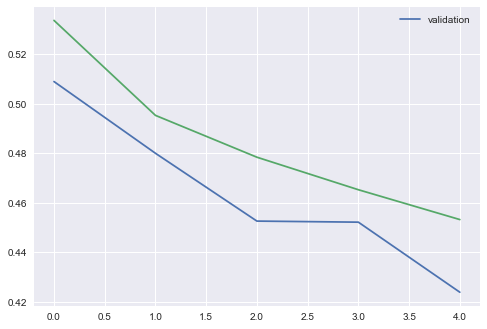

In [82]:
plt.plot(history.history['val_loss'],label = 'validation')
plt.plot(history.history['loss'])
plt.legend()

In [68]:
#model.save(MODEL_OUTPUT_FILEPATH)

KeyboardInterrupt: 

## Evaluation

In [88]:
y_pred_keras = model.predict(test_padded).ravel()

glove_roc = pd.DataFrame([test_labels, y_pred_keras]).T
glove_roc.columns = ['test_labels', 'y_pred_keras']
glove_roc.to_csv('glove_roc.csv')

In [198]:
model = keras.models.load_model(MODEL_OUTPUT_FILEPATH)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           57142400  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 57,222,901
Trainable params: 80,501
Non-trainable params: 57,142,400
_________________________________________________________________


#### Sample evaluation

In [190]:
import random
#test_neg = random.choice(neg.values)
i = random.choice(test_dataset.index)
if test_dataset.loc[i]['target'] == '0':
    print('negative: ', test_dataset.loc[i]['text'])
else:
    print('positive: ', test_dataset.loc[i]['text'])
test_sequences = text.tokenizer.texts_to_sequences([test_dataset.loc[i]['text']])
test_padded2 = pad_sequences(
    test_sequences, maxlen=text.max_length, padding="post", truncating="post"
)
model.predict(test_padded2)

positive:  ok pimp want


array([[0.52478486]], dtype=float32)

### Analytics

#### ROC graphs

In [191]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_padded).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras)

In [192]:
#inverse the labels to get the negative rates
inversed_y_pred_keras = pd.DataFrame(y_pred_keras).apply(lambda x: abs(x-1))
#false positivee is true negative here and true positive is false negative
tnr_keras, fnr_keras, thresholds_keras2 = roc_curve(test_labels, inversed_y_pred_keras)

In [32]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras2 = auc(fnr_keras, tnr_keras)

NameError: name 'fpr_keras' is not defined

In [33]:
model

NameError: name 'model' is not defined

In [194]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(train_padded, train_labels)

y_pred_rf = rf.predict_proba(test_padded)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_labels, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

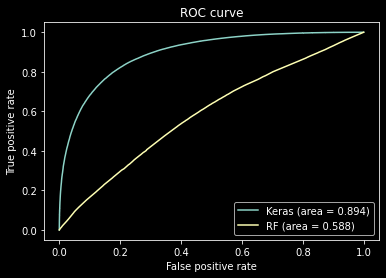

In [195]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [113]:
test_labels

969154     0.0
1440799    1.0
1277006    0.0
779736     1.0
627404     0.0
          ... 
1039860    1.0
58323      1.0
1061774    1.0
682557     1.0
1004894    1.0
Name: target, Length: 20000, dtype: float64

#### Confusion Matrix

In [156]:
df = pd.DataFrame(y_pred_keras, columns = ["predicted"])
#make predictions either 0 or 1
df["predicted"] = df["predicted"].apply(lambda x: round(x))
test_labels.index = df.index
df = pd.concat([df,test_labels], axis =1)
df

,predicted,target
0,0,0.0
1,1,1.0
2,0,0.0
3,1,1.0
4,1,0.0
...,...,...
19995,1,1.0
19996,1,1.0
19997,1,1.0
19998,1,1.0


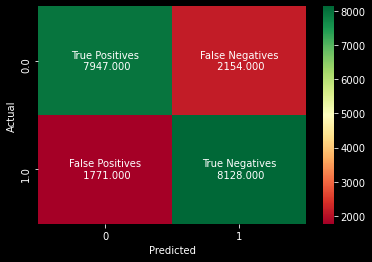

In [160]:
import seaborn as sn
confusion_matrix = pd.crosstab(df['target'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
strings = strings = np.asarray([['True Positives\n', 'False Negatives\n'],
                                ['False Positives\n', 'True Negatives\n']])
labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(strings.flatten(),
                                               confusion_matrix.values.flatten())])
         ).reshape(2, 2)

fig, ax = plt.subplots()
sn.heatmap(confusion_matrix, annot=labels, fmt="", cmap='RdYlGn', ax=ax)
plt.show()


In [165]:
tp = confusion_matrix[0][0]
fn = confusion_matrix[1][0]

tn = confusion_matrix[1][1]
fp = confusion_matrix[0][1]

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)

Sensitivity:  0.7867537867537867
Specificity:  0.8210930397009799
